In [1]:
!python3 --version

Python 3.8.11


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas
import ast

color_map = {'DNA':'c','ER':'g','RNA':'y','AGP':'r','Mito':'m','Brightfield':'lightgray','BFLow':'dimgrey','BFHigh':'darkgrey'}

# https://stackoverflow.com/a/56338489
def drawPieMarker(xs, ys, ratios, sizes, colors,ax):
    assert sum(ratios) <= 1, 'sum of ratios needs to be < 1'

    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 10)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 10)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})

    # scatter each of the pie pieces to create pies
    if xs <7:
        jitter = np.random.uniform(-.3,.3)
    else:
        jitter=0
    for marker in markers:
        ax.scatter(xs+jitter, ys, **marker,alpha=0.7)

def plot_channel_rep(combo_df,channel,size=150):
    channel_df = combo_df[combo_df['Dropout'].map(set([channel]).issubset)]
    plt.rcParams['font.size'] = '16'

    x=[]
    y=[]
    ratios=[]
    sizes=[]
    colors=[]
    for _,row in channel_df.iterrows():
        #print(row['Dropout'],row['Remaining'])
        left = len(row['Remaining'])
        x.append(float(left))
        comparison = float(combo_df[combo_df.Remaining.apply(lambda x: set(x) == set(row['Remaining']+[channel]))]['Mean'])
        value = float(combo_df[combo_df.Remaining.apply(lambda x: set(x) == set(row['Remaining']))]['Mean'])
        y.append((comparison-value)*100)
        sizes.append(size)
        if left >0:
            ratios.append([float(1)/float(left)]*left)
        else:
            ratios.append([0])
        colors.append([color_map[x] for x in row['Remaining']])

    fig, ax = plt.subplots(figsize=(14, 6))
    for plot in range(len(x)):
        if ratios[plot]!= [0]:
            drawPieMarker(xs=x[plot],
                        ys=y[plot],
                        ratios=ratios[plot],
                        sizes=sizes[plot],
                        colors=colors[plot],ax=ax)
        else:
            ax.plot(0,y[plot],marker='x',alpha=0.7,color='k',ms=12,label='_nolegend_')

    plt.xlabel('Channels already present')
    plt.ylabel('Change in Percent Replicating')
    plt.title(f'Change in Percent Replicating when adding {channel} to n other channels')
    label_list = []
    for eachchannel in color_map.keys():
        if eachchannel != channel:
            label_list.append(mpatches.Patch(color=color_map[eachchannel],label=eachchannel))

    ax.legend(handles=label_list,loc=1,ncol=4)
    ax.set_ylim((-2.5,5))
    plt.savefig(f"../figures/ChannelAdditionPercentReplicating-{channel}.png",dpi=300)

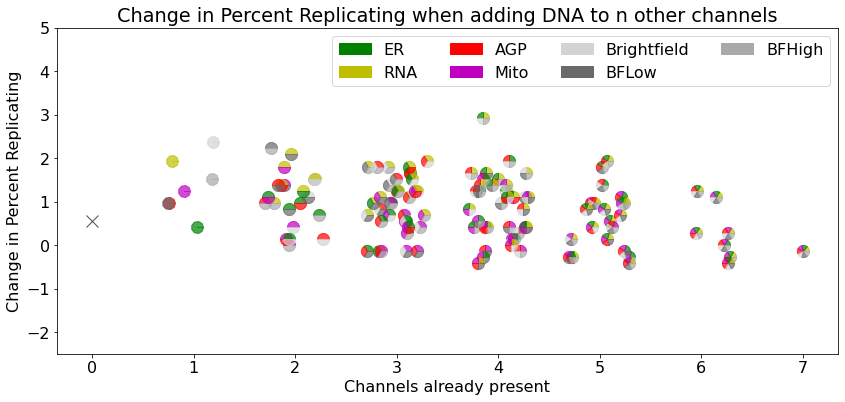

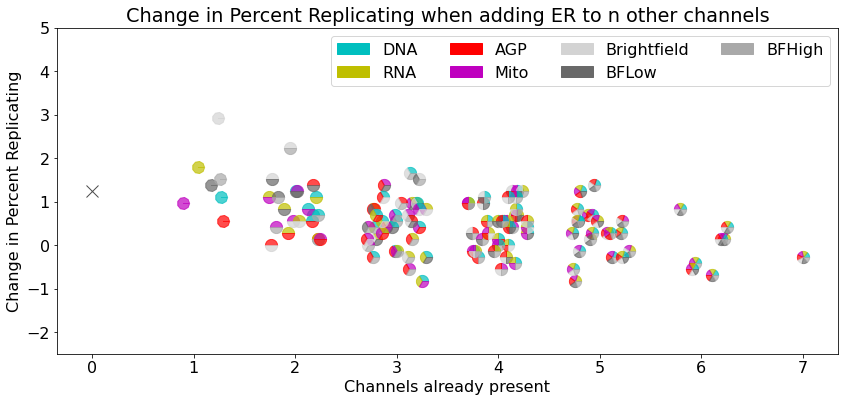

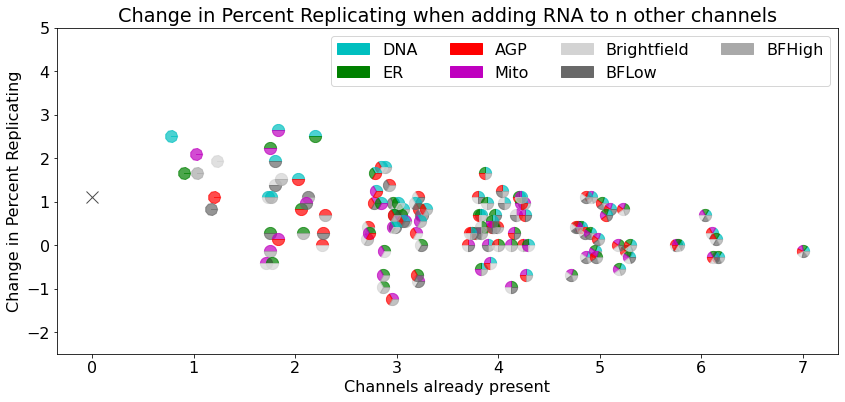

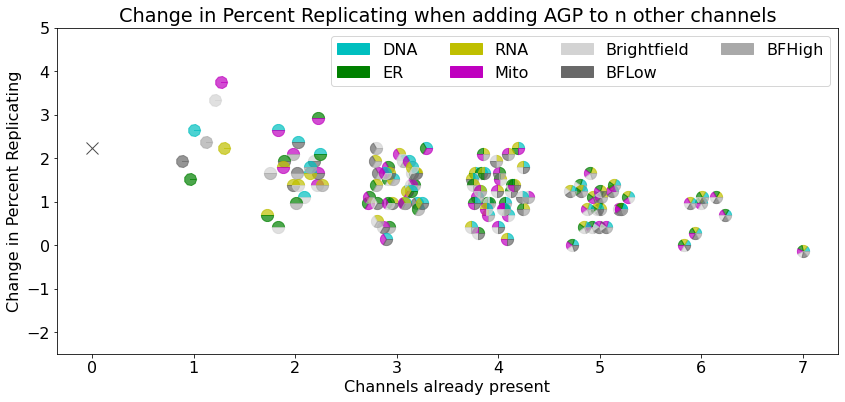

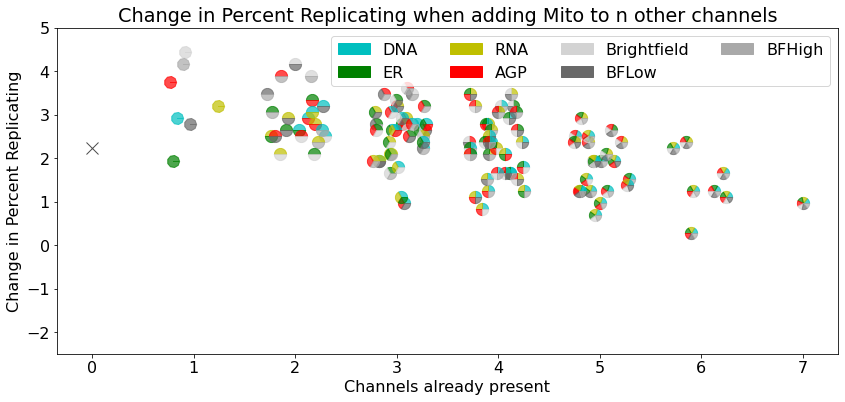

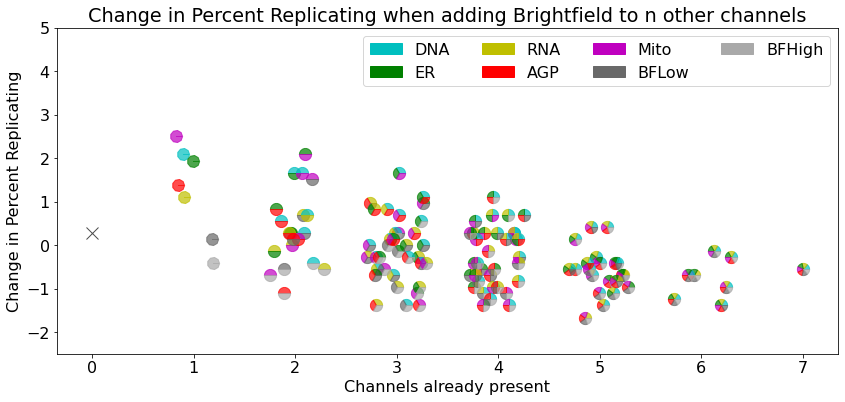

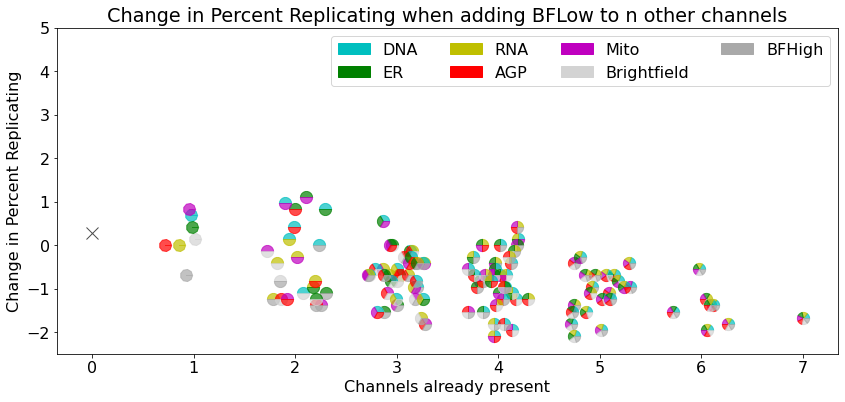

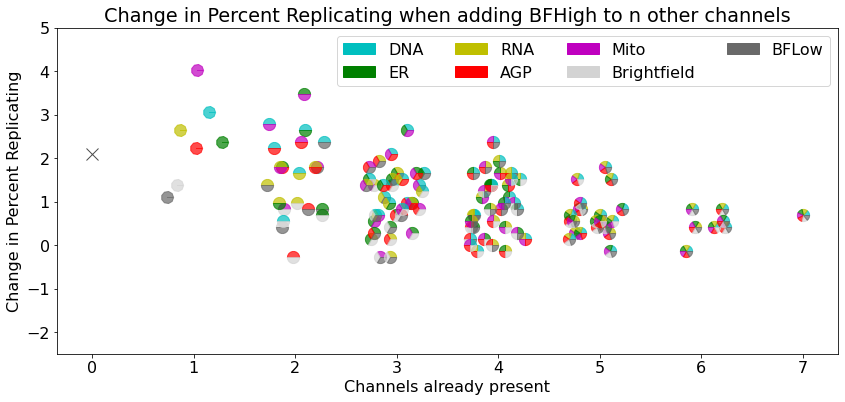

In [3]:

combo_df = pandas.read_csv('checkpoint_csvs/channel_dropout_combinations.csv',converters={'Dropout':ast.literal_eval,'Remaining':ast.literal_eval})
for eachchannel in color_map.keys():
    plot_channel_rep(combo_df,eachchannel)